In [0]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

     |████████████████████████████████| 798kB 2.8MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=a772017ceee5eed8841e6846a9b92592fa222732dda55d98359b156992eb1df5
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


In [0]:
def plotseird(t, S, E, I, Iso, R, D, R0=None):
    f, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, Iso, 'orange', alpha=0.7, linewidth=2, label='Isolated')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S + E + I + Iso + R + D, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if L is not None:
        plt.title("Lockdown after {} days".format(L))
    plt.show();        

    if R0 is not None:
        # sp1
        f = plt.figure(figsize=(12, 4))
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

        plt.show()

In [0]:
def deriv(y, t, N, beta, gamma, delta, em, cm, Is, rho1, rho2, phi, epsilon, d1, r1, d2, r2, SD, miu, f1, f2):
    S, E, I, Iso, R, D = y
    # individuals in the infectious compartement are 100% infectious, thus proportion is 1.
    force_of_infection = beta * SD * (1 - (em * cm)) * (I + (miu * Iso)) / N
    dSdt = -force_of_infection * S
    dEdt = force_of_infection * S - delta * E
    dIdt = f1 * delta * E - (Is * phi + d1 * rho1 + r1 * gamma) * I
    dIsodt = f2 * delta * E + Is * phi * I - (epsilon * r2 + rho2 * d2) * Iso
    dRdt = gamma * r1 * I + epsilon * r2 * Iso
    dDdt = rho1 * d1 * I + rho2 * d2 * Iso
    return dSdt, dEdt, dIdt, dIsodt, dRdt, dDdt

In [0]:
N = 3_200_000
Face_Mask_Efficacy = 0.25
Face_Mask_Coverage = 0.85
Isolation_Proportion = 0.25
Isolation_Time = 14
Social_Distancing = 1
Relative_Infectiousness_of_Hospitalized = 0.2
Proportion_of_Exposed_Infectious = 0.6
# In Days
Time_To_Isolate = 5
# days after infection until death
Death_Day_of_the_Infected = 10
# days after isolation until death
Death_Day_of_the_Isolated = 4

# Proportions
Death_Proportion_of_the_Infected = 0.01
Death_Proportion_of_the_Isolated = 0.01
Infected_to_Recovery_Proportion = (1 - (Isolation_Proportion + Death_Proportion_of_the_Infected))
Isolation_to_Recovery_Proportion = 1 - Death_Proportion_of_the_Isolated
Proportion_of_Exposed_Isolated = 1 - Proportion_of_Exposed_Infectious
SD = Social_Distancing
miu = Relative_Infectiousness_of_Hospitalized
phi = 1 / Time_To_Isolate
rho1 = 1 / Death_Day_of_the_Infected
rho2 = 1 / Death_Day_of_the_Isolated
epsilon = 1 / 14
Is = Isolation_Proportion
em = Face_Mask_Efficacy
cm = Face_Mask_Coverage
d1 = Death_Proportion_of_the_Infected
r1 = Infected_to_Recovery_Proportion
d2 = Death_Proportion_of_the_Isolated
r2 = Isolation_to_Recovery_Proportion
f1 = Proportion_of_Exposed_Infectious
f2 = Proportion_of_Exposed_Isolated
D = 7.0  # infections lasts seven days
gamma = 1.0 / D
delta = 1.0 / 5.2  # incubation period
R_0 = 3.85
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
E0 = 0.1 * N
# initial conditions: E0 = 10% of N
S0, E0, I0, Iso0, R0, D0 = N - E0 - I0 - Iso0 - R0 - D0, E0, 582, 425, 152, 5

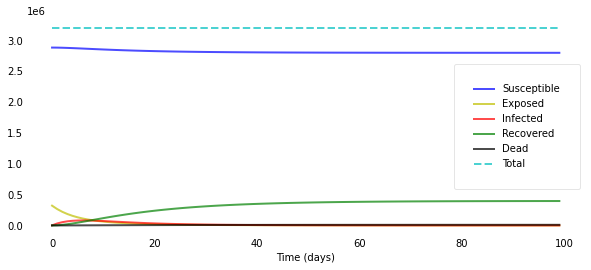

In [0]:
t = np.linspace(0, 99, 100)  # Grid of time points (in days)
y0 = S0, E0, I0, Iso0, R0, D0  # Initial conditions vector

ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, em, cm, Is, rho1, rho2, phi, epsilon, d1, r1, d2, r2, SD, miu, f1, f2))
S, E, I, Iso, R, D = ret.T

plotseird(t, S, E, I, Iso, R, D)

In [0]:
def deriv_ro(y, t, N, beta, gamma, delta, em, cm, Is, rho1, rho2, phi, epsilon, d1, r1, d2, r2, SD, miu, f1, f2):
    S, E, I, Iso, R, D = y
    # individuals in the infectious compartement are 100% infectious, thus proportion is 1.
    force_of_infection = beta(t) * SD * (1 - (em * cm)) * (I + (miu * Iso)) / N
    dSdt = -force_of_infection * S
    dEdt = force_of_infection * S - delta * E
    dIdt = f1 * delta * E - (Is * phi + d1 * rho1 + r1 * gamma) * I
    dIsodt = f2 * delta * E + Is * phi * I - (epsilon * r2 + rho2 * d2) * Iso
    dRdt = gamma * r1 * I + epsilon * r2 * Iso
    dDdt = rho1 * d1 * I + rho2 * d2 * Iso
    return dSdt, dEdt, dIdt, dIsodt, dRdt, dDdt

In [0]:
R_0_start, k, x0, R_0_end = 3.85, 0.5, 50, 0.5


def logistic_R_0(t):
    return (R_0_start - R_0_end) / (1 + np.exp(-k * (-t + x0))) + R_0_end


def beta(t):
    return logistic_R_0(t) * gamma

In [0]:
ret = odeint(deriv_ro, y0, t, args=(N, beta, gamma, delta, em, cm, Is, rho1, rho2, phi, epsilon, d1, r1, d2, r2, SD, miu, f1, f2))
S, E, I, Iso, R, D = ret.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values

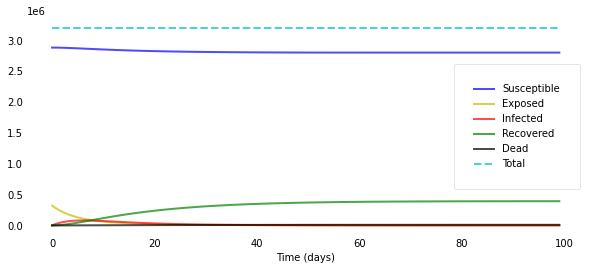

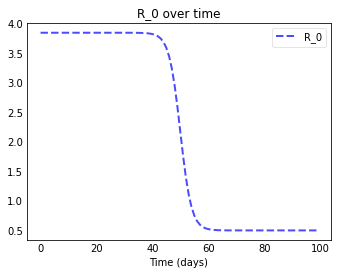

In [0]:
plotseird(t, S, E, I, Iso, R, D, R0=R0_over_time)